# Benchmark

## Imports

In [1]:
import cProfile
from data import Dataset
from knns.base import KNNSBase
from knns.bkmeans_hnsw import BisectingKmeansHNSW
from knns.bkmeans_hnsw_2 import BisectingKmeansHNSW2
from knns.bkmeans_hnsw_3 import BisectingKmeansHNSW3
from knns.exhaustive import ExhaustiveKnn
from knns.hnsw import HNSW
from knns.hnsw import HNSW_Graph
from knns.ihnsw import IterativeHNSW
from knns.ivf import IVF
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pstats
from random import sample
from sklearn.cluster import KMeans
from tabulate import tabulate
from time import time

## Loading data

In [2]:
db_name = 'sift1m'
dataset = Dataset()
dataset.load_from_tfds(db_name) 

## Indexing

### Exhaustive

In [11]:
exhaustive = ExhaustiveKnn()
exhaustive.insert(dataset.get_db_embeddings()) # 0.0s

### HNSW

In [6]:
hnsw = HNSW(m=20, ef_construction=100, ef=100)
hnsw.insert(dataset.get_db_embeddings()) # 597m 27.5s

0: 0.0s
100: 0.19962811470031738s
200: 0.5098748207092285s
300: 0.5889444351196289s
400: 0.6312532424926758s
500: 0.7235391139984131s
600: 0.7437593936920166s
700: 0.763995885848999s
800: 0.8318111896514893s
900: 0.8739163875579834s
1000: 0.9203319549560547s
1100: 0.9385831356048584s
1200: 0.9649417400360107s
1300: 1.0016374588012695s
1400: 1.0220370292663574s
1500: 1.0747530460357666s
1600: 1.138777494430542s
1700: 1.1352894306182861s
1800: 1.1150732040405273s
1900: 1.1447944641113281s
2000: 1.1520929336547852s
2100: 1.1660027503967285s
2200: 1.2089991569519043s
2300: 1.2468719482421875s
2400: 1.2622861862182617s
2500: 1.2636220455169678s
2600: 1.304828405380249s
2700: 1.3024365901947021s
2800: 1.3651719093322754s
2900: 1.3672153949737549s
3000: 1.4068877696990967s
3100: 1.446767807006836s
3200: 1.4611847400665283s
3300: 1.4491314888000488s
3400: 1.4399864673614502s
3500: 1.4359338283538818s
3600: 1.4306104183197021s
3700: 1.4304282665252686s
3800: 1.4810779094696045s
3900: 1.53606009

In [7]:
with open(f'../data/hnsw_{db_name}.pkl', 'wb') as file:
    pickle.dump(hnsw, file, pickle.HIGHEST_PROTOCOL)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



### IVF

In [3]:
ivf = IVF(n_buckets=1024, n_probes=8)
ivf.insert(dataset.get_db_embeddings()) # 10m 0.6s

In [6]:
with open(f'../data/ivf_{db_name}.pkl', 'wb') as file:
    pickle.dump(ivf, file, pickle.HIGHEST_PROTOCOL)

### Iterative HNSW

In [4]:
ihnsw = IterativeHNSW(m=20, ef_construction=100, ef=100, n_clusters=1024, n_probes=1024)
ihnsw.graph = hnsw.graph
kmeans = KMeans(n_clusters=ihnsw.n_clusters, random_state=0)
kmeans.fit(dataset.get_db_embeddings())
ihnsw.centroids = kmeans.cluster_centers_
ihnsw.labels = kmeans.labels_

In [12]:
with open(f'../data/ihnsw_{db_name}.pkl', 'wb') as file:
    pickle.dump(ihnsw, file, pickle.HIGHEST_PROTOCOL)

### BiscectingKMeans HNSW

In [3]:
bhnsw = BisectingKmeansHNSW(m=20, ef_construction=100, ef=100, max_clusters=1024)
bhnsw.insert(dataset.get_db_embeddings()) # 716m 57.2s

layers selected: 1
layers selected: 21
layers selected: 421
layers selected: 8421
layers selected: 168421
layers selected: 1000000
0: 0.0s
100: 0.20403170585632324s
200: 0.6240799427032471s
300: 0.8386642932891846s
400: 0.9139688014984131s
500: 1.1662993431091309s
600: 1.2896757125854492s
700: 0.8949465751647949s
800: 0.9632205963134766s
900: 0.9743697643280029s
1000: 1.032531976699829s
1100: 1.0049991607666016s
1200: 1.0420012474060059s
1300: 1.13930082321167s
1400: 1.2322204113006592s
1500: 1.22198486328125s
1600: 1.21889066696167s
1700: 1.2262914180755615s
1800: 1.271641731262207s
1900: 1.4048469066619873s
2000: 1.2633249759674072s
2100: 1.34956693649292s
2200: 1.2873458862304688s
2300: 1.4612061977386475s
2400: 1.379807472229004s
2500: 1.2889983654022217s
2600: 1.427001953125s
2700: 1.3609981536865234s
2800: 1.420999526977539s
2900: 1.426652431488037s
3000: 1.4576494693756104s
3100: 1.464000940322876s
3200: 1.4660000801086426s
3300: 1.4630000591278076s
3400: 1.5029988288879395s
350

In [4]:
with open(f'../data/bhnsw_{db_name}.pkl', 'wb') as file:
    pickle.dump(bhnsw, file, pickle.HIGHEST_PROTOCOL)

### BiscectingKMeans HNSW 2

In [25]:
from sklearn.cluster import BisectingKMeans

bhnsw2 = BisectingKmeansHNSW2(m=20, ef_construction=100, ef=100, max_clusters=1024)
bhnsw2.graph = bhnsw.graph

layer = 0
layer_increment_size = 1
while layer_increment_size <= bhnsw2.max_clusters:
    kmeans = BisectingKMeans(n_clusters=layer_increment_size, bisecting_strategy='largest_cluster', random_state=0)
    kmeans.fit(dataset.get_db_embeddings())
    bhnsw2.cluster_labels.append(kmeans.labels_)
    print(f"layer {layer}")
    layer += 1
    layer_increment_size = bhnsw2.m*layer_increment_size

layer 0
layer 1
layer 2


In [67]:
with open(f'../data/bhnsw2_{db_name}.pkl', 'wb') as file:
    pickle.dump(bhnsw2, file, pickle.HIGHEST_PROTOCOL)

### BiscectingKMeans HNSW 3

In [41]:
bhnsw3 = BisectingKmeansHNSW3(m=20, ef_construction=100, ef=100, max_clusters=1024)
bhnsw3.graph = bhnsw.graph
bhnsw3.labels = bhnsw2.cluster_labels[-1]

## Testing

### Test routine

In [30]:
def test_ann(ann:KNNSBase, k=100):
    print(f"Test: algorithm={ann.__class__.__name__} dataset={db_name}")
    recalls = []
    deltas = []
    distance_calculation_counts = []
    for i in range(dataset.get_test_size()):
        query = dataset.get_test_embedding(i)
        start = time()
        ann_results = ann.search(query, k)
        end = time()
        recall = dataset.get_test_recall(i, ann_results)
        recalls.append(recall)
        delta = end-start
        deltas.append(delta)
        with cProfile.Profile() as profile:
            ann_results = ann.search(query, k)
        stats = pstats.Stats(profile)
        distance_calculation_count = int(stats.get_stats_profile().func_profiles['get_distance'].ncalls)
        distance_calculation_counts.append(distance_calculation_count)
        print(f"test {i}: recall@{k}={recall} time={round(delta, 4)} distance calculations={distance_calculation_count}")
    avg_recalls = round(sum(recalls)/len(recalls), 4)
    avg_deltas = round(sum(deltas)/len(deltas), 4)
    avg_distance_calculation_counts = round(sum(distance_calculation_counts)/len(distance_calculation_counts), 4)
    print(f"Final results (avg): recall@{k}={avg_recalls} time={avg_deltas} distance calculations={avg_distance_calculation_counts}")
    return recalls, deltas, distance_calculation_counts

### Exhaustive

In [12]:
recalls, deltas, distance_calculation_counts = test_ann(exhaustive) # 636m 20.3s

Test: algorithm=ExhaustiveKnn dataset=sift1m
test 0: recall@100=1.0 time=3.899
test 1: recall@100=1.0 time=3.875
test 2: recall@100=1.0 time=3.866
test 3: recall@100=1.0 time=3.812
test 4: recall@100=1.0 time=3.786
test 5: recall@100=1.0 time=3.849
test 6: recall@100=1.0 time=3.92
test 7: recall@100=1.0 time=3.832
test 8: recall@100=1.0 time=3.805
test 9: recall@100=1.0 time=3.809
test 10: recall@100=1.0 time=3.836
test 11: recall@100=1.0 time=3.809
test 12: recall@100=1.0 time=3.815
test 13: recall@100=1.0 time=3.793
test 14: recall@100=1.0 time=3.826
test 15: recall@100=1.0 time=3.821
test 16: recall@100=1.0 time=3.816
test 17: recall@100=1.0 time=3.819
test 18: recall@100=1.0 time=3.802
test 19: recall@100=1.0 time=3.813
test 20: recall@100=1.0 time=3.866
test 21: recall@100=1.0 time=3.819
test 22: recall@100=1.0 time=3.81
test 23: recall@100=1.0 time=3.866
test 24: recall@100=1.0 time=3.941
test 25: recall@100=1.0 time=3.879
test 26: recall@100=1.0 time=3.838
test 27: recall@100=1.

In [13]:
np.save(f"../data/exhaustive_{db_name}_recalls.npy", recalls)
np.save(f"../data/exhaustive_{db_name}_deltas.npy", deltas)

#### Recall analysis (why not 1.0?)

In [15]:
incorrect_tests = []
for i, recall in enumerate(recalls):
    if recall != 1.0:
        incorrect_tests.append(i)
len(incorrect_tests)

112

In [22]:
dubious_test_count = 0
for t in incorrect_tests:
    distances = [(i, exhaustive.get_distance(e, dataset.get_test_embedding(t))) for i, e in enumerate(dataset.get_db_embeddings())]
    distances.sort(key=lambda tup: tup[1])
    if distances[99][1] == distances[100][1]:
        dubious_test_count += 1
dubious_test_count

112

### HNSW

In [ ]:
with open(f'../data/hnsw_{db_name}.pkl', 'rb') as file:
    hnsw = pickle.load(file)

In [16]:
recalls, deltas, distance_calculation_counts = test_ann(hnsw)

Test: algorithm=HNSW dataset=sift1m
test 0: recall@100=0.86 time=0.066 distance calculations=2243
test 1: recall@100=0.83 time=0.067 distance calculations=2319
test 2: recall@100=0.98 time=0.059 distance calculations=2050
test 3: recall@100=0.96 time=0.034 distance calculations=1178
test 4: recall@100=0.88 time=0.06 distance calculations=2093
test 5: recall@100=0.78 time=0.065 distance calculations=2175
test 6: recall@100=0.92 time=0.074 distance calculations=2449
test 7: recall@100=0.99 time=0.035 distance calculations=1229
test 8: recall@100=0.82 time=0.073 distance calculations=2536
test 9: recall@100=0.92 time=0.063 distance calculations=2142
test 10: recall@100=0.76 time=0.066 distance calculations=2254
test 11: recall@100=0.92 time=0.061 distance calculations=2040
test 12: recall@100=0.9 time=0.063 distance calculations=2080
test 13: recall@100=0.92 time=0.067 distance calculations=2297
test 14: recall@100=0.79 time=0.064 distance calculations=2143
test 15: recall@100=0.88 time=0

In [21]:
np.save(f"../data/hnsw_{db_name}_recalls.npy", recalls)
np.save(f"../data/hnsw_{db_name}_deltas.npy", deltas)
np.save(f"../data/hnsw_{db_name}_calculations.npy", distance_calculation_counts)

### IVF

In [31]:
with open(f'../data/ivf_{db_name}.pkl', 'rb') as file:
    ivf = pickle.load(file)

In [33]:
recalls, deltas, distance_calculation_counts = test_ann(ivf)

Test: algorithm=IVF dataset=sift1m
test 0: recall@100=0.68 time=0.059 distance calculations=10065
test 1: recall@100=0.58 time=0.048 distance calculations=9007
test 2: recall@100=0.93 time=0.053 distance calculations=9874
test 3: recall@100=0.98 time=0.06 distance calculations=12042
test 4: recall@100=0.83 time=0.053 distance calculations=9472
test 5: recall@100=0.42 time=0.046 distance calculations=8121
test 6: recall@100=0.64 time=0.051 distance calculations=9781
test 7: recall@100=0.91 time=0.05 distance calculations=9292
test 8: recall@100=0.54 time=0.053 distance calculations=9983
test 9: recall@100=0.77 time=0.055 distance calculations=10439
test 10: recall@100=0.6 time=0.049 distance calculations=8666
test 11: recall@100=0.73 time=0.059 distance calculations=11219
test 12: recall@100=0.62 time=0.059 distance calculations=10411
test 13: recall@100=0.65 time=0.053 distance calculations=9468
test 14: recall@100=0.71 time=0.045 distance calculations=8284
test 15: recall@100=0.84 tim

In [34]:
np.save(f"../data/ivf_{db_name}_recalls.npy", recalls)
np.save(f"../data/ivf_{db_name}_deltas.npy", deltas)

In [35]:
np.save(f"../data/ivf_{db_name}_calculations.npy", distance_calculation_counts)

### Iterative HNSW

In [36]:
with open(f'../data/ihnsw_{db_name}.pkl', 'rb') as file:
    ihnsw = pickle.load(file)

In [7]:
ihnsw.n_probes = 64
recalls, deltas = test_ann(ihnsw)

Test: algorithm=IterativeHNSW dataset=sift1m
test 0: recall@100=0.9 time=0.172
test 1: recall@100=0.83 time=0.145
test 2: recall@100=0.98 time=0.111
test 3: recall@100=0.96 time=0.055
test 4: recall@100=0.91 time=0.1517
test 5: recall@100=0.85 time=0.189
test 6: recall@100=0.92 time=0.087
test 7: recall@100=0.99 time=0.051
test 8: recall@100=0.83 time=0.1211
test 9: recall@100=0.93 time=0.127
test 10: recall@100=0.79 time=0.213
test 11: recall@100=0.92 time=0.0677
test 12: recall@100=0.91 time=0.116
test 13: recall@100=0.93 time=0.1268
test 14: recall@100=0.8 time=0.1293
test 15: recall@100=0.9 time=0.1189
test 16: recall@100=0.91 time=0.1151
test 17: recall@100=0.81 time=0.121
test 18: recall@100=0.86 time=0.151
test 19: recall@100=0.87 time=0.0697
test 20: recall@100=0.99 time=0.074
test 21: recall@100=0.99 time=0.154
test 22: recall@100=0.94 time=0.113
test 23: recall@100=0.95 time=0.0865
test 24: recall@100=0.91 time=0.1176
test 25: recall@100=0.98 time=0.0837
test 26: recall@100=0

In [37]:
ihnsw.n_probes = 1024
recalls, deltas, distance_calculation_counts = test_ann(ihnsw)

Test: algorithm=IterativeHNSW dataset=sift1m
test 0: recall@100=0.9 time=0.175 distance calculations=7496
test 1: recall@100=0.83 time=0.151 distance calculations=6208
test 2: recall@100=0.98 time=0.107 distance calculations=5202
test 3: recall@100=0.96 time=0.048 distance calculations=2457
test 4: recall@100=0.91 time=0.156 distance calculations=7160
test 5: recall@100=0.85 time=0.163 distance calculations=8167
test 6: recall@100=0.92 time=0.086 distance calculations=4067
test 7: recall@100=0.99 time=0.045 distance calculations=2616
test 8: recall@100=0.83 time=0.128 distance calculations=5754
test 9: recall@100=0.93 time=0.127 distance calculations=5761
test 10: recall@100=0.79 time=0.201 distance calculations=8929
test 11: recall@100=0.92 time=0.076 distance calculations=3602
test 12: recall@100=0.91 time=0.107 distance calculations=5497
test 13: recall@100=0.93 time=0.126 distance calculations=5424
test 14: recall@100=0.8 time=0.119 distance calculations=5824
test 15: recall@100=0.

In [38]:
np.save(f"../data/ihnsw_{db_name}_recalls.npy", recalls)
np.save(f"../data/ihnsw_{db_name}_deltas.npy", deltas)
np.save(f"../data/ihnsw_{db_name}_calculations.npy", distance_calculation_counts)

In [15]:
hnsw_recalls = np.load(f"../data/hnsw_{db_name}_recalls.npy")
recall_differences = []
for i in range(len(recalls)):
    if recalls[i] != hnsw_recalls[i]:
        recall_differences.append(recalls[i]-hnsw_recalls[i])
print(f"affected rate = {len(recall_differences)/dataset.get_test_size()}")
print(f"recall gain = {sum(recall_differences)/len(recall_differences)}")

affected rate = 0.51
recall gain = 0.026041176470588994


### BiscectingKMeans HNSW

In [39]:
with open(f'../data/bhnsw_{db_name}.pkl', 'rb') as file:
    bhnsw = pickle.load(file)

In [26]:
recalls, deltas, distance_calculation_counts = test_ann(bhnsw)

Test: algorithm=BisectingKmeansHNSW dataset=sift1m
test 0: recall@100=0.84 time=0.063 distance calculations=2283
test 1: recall@100=0.79 time=0.069 distance calculations=2392
test 2: recall@100=0.95 time=0.055 distance calculations=1982
test 3: recall@100=0.97 time=0.035 distance calculations=1281
test 4: recall@100=0.91 time=0.056 distance calculations=2020
test 5: recall@100=0.8 time=0.066 distance calculations=2222
test 6: recall@100=0.95 time=0.078 distance calculations=2545
test 7: recall@100=0.98 time=0.035 distance calculations=1224
test 8: recall@100=0.91 time=0.071 distance calculations=2389
test 9: recall@100=0.9 time=0.06 distance calculations=2068
test 10: recall@100=0.87 time=0.065 distance calculations=2304
test 11: recall@100=0.92 time=0.065 distance calculations=2114
test 12: recall@100=0.94 time=0.059 distance calculations=2170
test 13: recall@100=0.95 time=0.078 distance calculations=2486
test 14: recall@100=0.75 time=0.068 distance calculations=2273
test 15: recall@1

In [27]:
np.save(f"../data/bhnsw_{db_name}_recalls.npy", recalls)
np.save(f"../data/bhnsw_{db_name}_deltas.npy", deltas)
np.save(f"../data/bhnsw_{db_name}_calculations.npy", distance_calculation_counts)

### BiscectingKMeans HNSW 2

In [40]:
with open(f'../data/bhnsw2_{db_name}.pkl', 'rb') as file:
    bhnsw2 = pickle.load(file)

In [26]:
recalls, deltas = test_ann(bhnsw2)

Test: algorithm=BisectingKmeansHNSW2 dataset=sift1m
test 0: recall@100=0.84 time=0.356
test 1: recall@100=0.79 time=0.247
test 2: recall@100=0.95 time=0.225
test 3: recall@100=0.97 time=0.069
test 4: recall@100=0.91 time=0.186
test 5: recall@100=0.8 time=0.197
test 6: recall@100=0.95 time=0.175
test 7: recall@100=0.98 time=0.203
test 8: recall@100=0.91 time=0.144
test 9: recall@100=0.9 time=0.083
test 10: recall@100=0.87 time=0.121
test 11: recall@100=0.92 time=0.097
test 12: recall@100=0.94 time=0.081
test 13: recall@100=0.95 time=0.095
test 14: recall@100=0.75 time=0.109
test 15: recall@100=0.85 time=0.081
test 16: recall@100=0.93 time=0.073
test 17: recall@100=0.77 time=0.067
test 18: recall@100=0.85 time=0.093
test 19: recall@100=0.89 time=0.06
test 20: recall@100=0.99 time=0.103
test 21: recall@100=0.96 time=0.058
test 22: recall@100=0.96 time=0.041
test 23: recall@100=0.97 time=0.064
test 24: recall@100=0.92 time=0.054
test 25: recall@100=0.96 time=0.057
test 26: recall@100=0.93 

In [27]:
np.save(f"../data/bhnsw2_{db_name}_recalls.npy", recalls)
np.save(f"../data/bhnsw2_{db_name}_deltas.npy", deltas)

### BiscectingKMeans HNSW 3

In [42]:
recalls, deltas, distance_calculation_counts = test_ann(bhnsw3)

Test: algorithm=BisectingKmeansHNSW3 dataset=sift1m
test 0: recall@100=0.84 time=0.2662 distance calculations=4003
test 1: recall@100=0.82 time=0.229 distance calculations=9117
test 2: recall@100=0.95 time=0.072 distance calculations=3321
test 3: recall@100=0.97 time=0.049 distance calculations=2382
test 4: recall@100=0.93 time=0.115 distance calculations=5027
test 5: recall@100=0.8 time=0.182 distance calculations=7770
test 6: recall@100=0.96 time=0.11 distance calculations=5305
test 7: recall@100=0.98 time=0.049 distance calculations=2296
test 8: recall@100=0.92 time=0.104 distance calculations=5178
test 9: recall@100=0.92 time=0.114 distance calculations=5131
test 10: recall@100=0.9 time=0.188 distance calculations=8852
test 11: recall@100=0.93 time=0.115 distance calculations=5102
test 12: recall@100=0.94 time=0.075 distance calculations=3479
test 13: recall@100=0.96 time=0.124 distance calculations=5370
test 14: recall@100=0.77 time=0.129 distance calculations=5621
test 15: recall

In [43]:
np.save(f"../data/bhnsw3_{db_name}_recalls.npy", recalls)
np.save(f"../data/bhnsw3_{db_name}_deltas.npy", deltas)
np.save(f"../data/bhnsw3_{db_name}_calculations.npy", distance_calculation_counts)

## Analysis

### Recall / Query time / Distance calculations

In [44]:
method_names = ("IVF", "HNSW", "bHNSW", "iHNSW", "bHNSW3")
results = []
for method_name in method_names:
    deltas = np.load(f"../data/{method_name.lower()}_{db_name}_deltas.npy")
    recalls = np.load(f"../data/{method_name.lower()}_{db_name}_recalls.npy")
    calculations = np.load(f"../data/{method_name.lower()}_{db_name}_calculations.npy")
    results.append((method_name, sum(deltas)/len(deltas), sum(calculations)/len(calculations), sum(recalls)/len(recalls)))
results.sort(key=lambda t: t[3], reverse=True)

In [45]:
print(tabulate(results, headers=["method", "query time (s)", "distance calculations", "recall@100"]))

method      query time (s)    distance calculations    recall@100
--------  ----------------  -----------------------  ------------
bHNSW3           0.0904975                  4220.97      0.923576
iHNSW            0.101112                   4743.77      0.922465
bHNSW            0.0556182                  1931.78      0.915216
HNSW             0.0553598                  1914.98      0.909184
IVF              0.0513566                  9496.01      0.773231


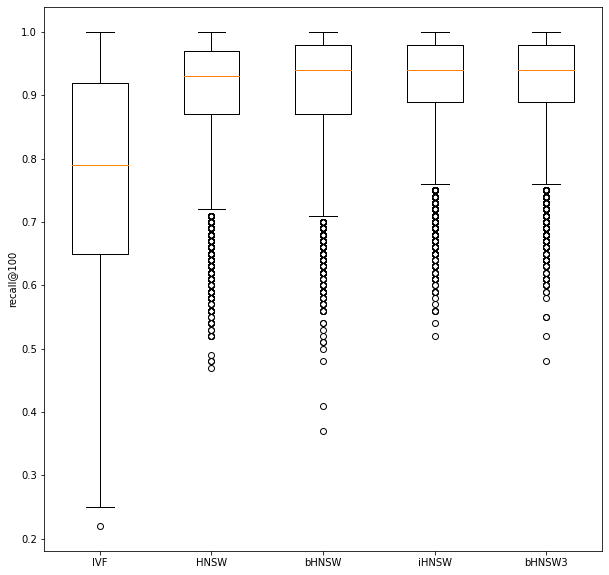

In [46]:
recalls = [np.load(f"../data/{method_name.lower()}_{db_name}_recalls.npy") for method_name in method_names]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylabel('recall@100')
bplot = ax.boxplot(recalls, labels=method_names)

plt.show()

In [48]:
from math import ceil, floor, sqrt

from numpy import argmin

for i in range(len(method_names)):
    mean = sum(recalls[i])/len(recalls[i])
    s2 = (sum((x-mean)**2 for x in recalls[i]))/(len(recalls[i])-1)
    s = sqrt(s2)  
    recalls[i].sort()  
    if len(recalls[i])%2 == 0:
        median = (recalls[i][floor(len(recalls[i])/2)] + recalls[i][ceil(len(recalls[i])/2)]) / 2
    else:
        median = recalls[i][ceil(len(recalls[i])/2)]
    print(f"{method_names[i]}: mean = {round(mean, 4)} std deviation = {round(s, 4)} median = {round(median, 4)}")

IVF: mean = 0.7732 std deviation = 0.1682 median = 0.79
HNSW: mean = 0.9092 std deviation = 0.0837 median = 0.93
bHNSW: mean = 0.9152 std deviation = 0.0786 median = 0.94
iHNSW: mean = 0.9225 std deviation = 0.0712 median = 0.94
bHNSW3: mean = 0.9236 std deviation = 0.0707 median = 0.94


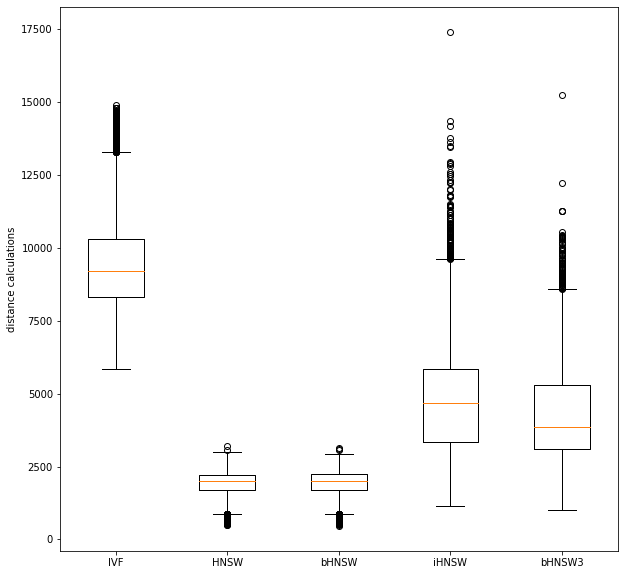

In [49]:
calculations = [np.load(f"../data/{method_name.lower()}_{db_name}_calculations.npy") for method_name in method_names]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylabel('distance calculations')
bplot = ax.boxplot(calculations, labels=method_names)

plt.show()

In [50]:
from math import ceil, floor, sqrt

for i in range(len(method_names)):
    mean = sum(calculations[i])/len(calculations[i])
    s2 = (sum((x-mean)**2 for x in calculations[i]))/(len(calculations[i])-1)
    s = sqrt(s2)
    calculations[i].sort()
    if len(calculations[i])%2 == 0:
        median = (calculations[i][floor(len(calculations[i])/2)] + calculations[i][ceil(len(calculations[i])/2)]) / 2
    else:
        median = calculations[i][ceil(len(calculations[i])/2)]
    print(f"{method_names[i]}: mean = {round(mean, 4)} std deviation = {round(s, 4)} median = {round(median, 4)}")

IVF: mean = 9496.0139 std deviation = 1627.1696 median = 9194.0
HNSW: mean = 1914.9785 std deviation = 416.0667 median = 1999.0
bHNSW: mean = 1931.7773 std deviation = 422.128 median = 2017.0
iHNSW: mean = 4743.7681 std deviation = 1807.378 median = 4670.0
bHNSW3: mean = 4220.9683 std deviation = 1514.3625 median = 3845.0


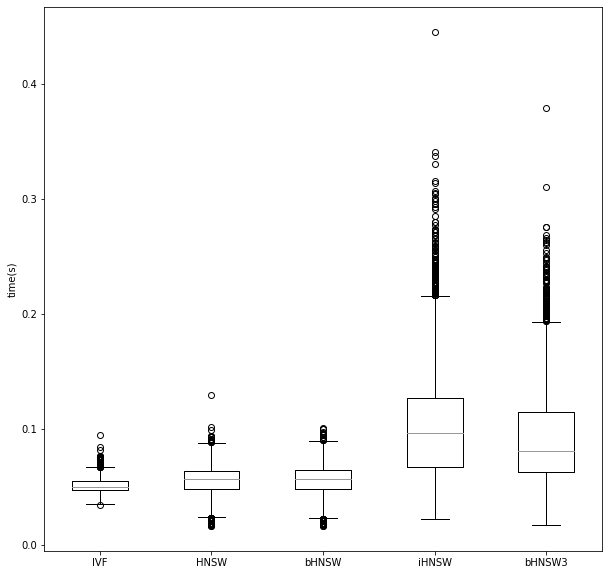

In [52]:
deltas = [np.load(f"../data/{method_name.lower()}_{db_name}_deltas.npy") for method_name in method_names]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylabel('time(s)')
bplot = ax.boxplot(deltas, labels=method_names)

plt.show()

In [53]:
from math import ceil, floor, sqrt

for i in range(len(method_names)):
    mean = sum(deltas[i])/len(deltas[i])
    s2 = (sum((x-mean)**2 for x in deltas[i]))/(len(deltas[i])-1)
    s = sqrt(s2)
    deltas[i].sort()
    if len(deltas[i])%2 == 0:
        median = (deltas[i][floor(len(deltas[i])/2)] + deltas[i][ceil(len(deltas[i])/2)]) / 2
    else:
        median = deltas[i][ceil(len(deltas[i])/2)]
    print(f"{method_names[i]}: mean = {round(mean, 4)} std deviation = {round(s, 4)} median = {round(median, 4)}")

IVF: mean = 0.0514 std deviation = 0.0068 median = 0.05
HNSW: mean = 0.0554 std deviation = 0.0127 median = 0.057
bHNSW: mean = 0.0556 std deviation = 0.0129 median = 0.057
iHNSW: mean = 0.1011 std deviation = 0.0434 median = 0.097
bHNSW3: mean = 0.0905 std deviation = 0.0373 median = 0.081


#### Recall / Query time (Old tests)

In [71]:
method_names = ("Exhaustive", "HNSW", "IVF", "iHNSW", "bHNSW", "bHNSW2", "bHNSW3")
results = []
for method_name in method_names:
    deltas = np.load(f"../data/{method_name.lower()}_{db_name}_deltas.npy")
    recalls = np.load(f"../data/{method_name.lower()}_{db_name}_recalls.npy")
    results.append((method_name, sum(deltas)/len(deltas), sum(recalls)/len(recalls)))
results.sort(key=lambda t: t[2], reverse=True)

In [72]:
print(tabulate(results, headers=["method", "query time (s)", "recall@100"]))

method        query time (s)    recall@100
----------  ----------------  ------------
Exhaustive         3.81786        0.999888
bHNSW3             0.0888392      0.923576
iHNSW              0.102314       0.922465
bHNSW2             0.0376289      0.915259
bHNSW              0.0331098      0.915216
HNSW               0.0335731      0.909184
IVF                0.0512113      0.773231


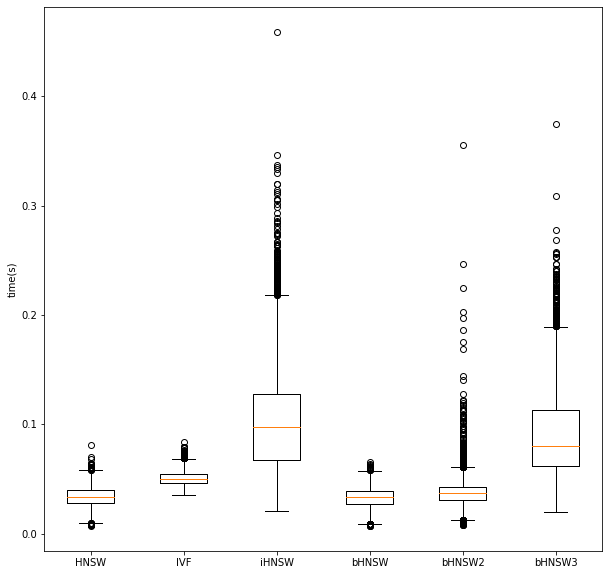

In [73]:
deltas = [np.load(f"../data/{method_name.lower()}_{db_name}_deltas.npy") for method_name in method_names[1:]]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylabel('time(s)')
bplot = ax.boxplot(deltas, labels=list(method_names[1:]))

plt.show()

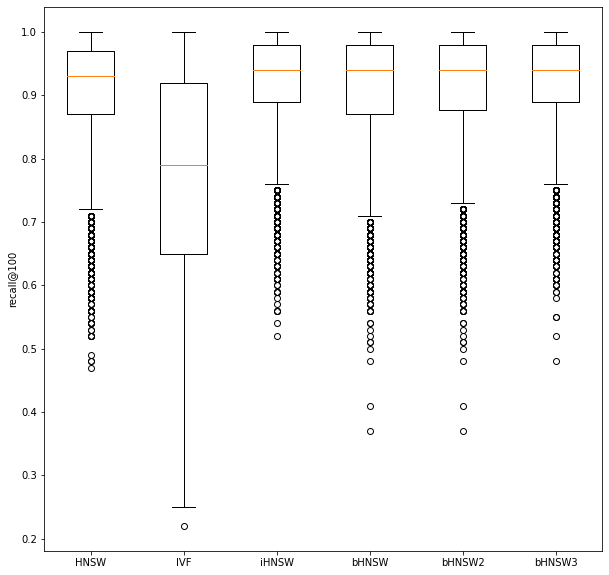

In [74]:
recalls = [np.load(f"../data/{method_name.lower()}_{db_name}_recalls.npy") for method_name in method_names[1:]]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_ylabel('recall@100')
bplot = ax.boxplot(recalls, labels=method_names[1:])

plt.show()

### Clustering Plotting

#### Plotting routine

In [22]:
def plot_clustering(d:Dataset, labels, only_label=None):
    all_values = [abs(e[0]) for e in d.pca_db] + [abs(e[1]) for e in d.pca_db]
    limit = max(all_values)
    limit += limit/10
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    fig = plt.gcf()
    if only_label != None:
        fig.set_size_inches(5, 5)
    else:
        fig.set_size_inches(10, 10)

    db_embeddings = np.array(d.pca_db)
    if only_label == None:
        for i in np.unique(labels):
            plt.scatter(db_embeddings[labels == i , 0] , db_embeddings[labels == i , 1] , label = i)
    else:
        plt.scatter(db_embeddings[labels == only_label , 0] , db_embeddings[labels == only_label , 1] , label = only_label)
        plt.title(f"cluster {only_label}")
    plt.show()

#### K-Means

In [16]:
kmeans = KMeans(n_clusters=1024, random_state=0)
labels = kmeans.fit_predict(dataset.get_db_embeddings())

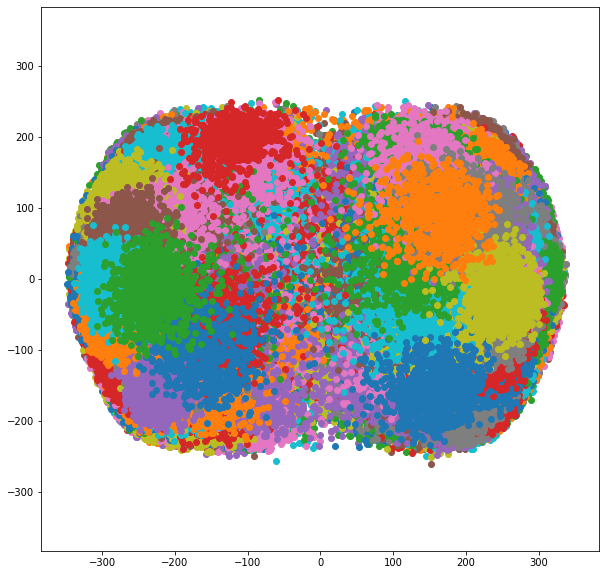

In [17]:
plot_clustering(dataset, labels)

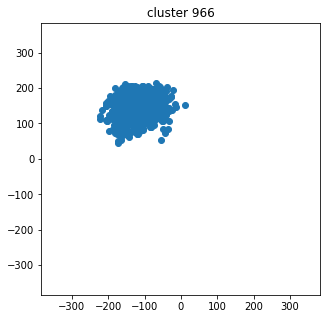

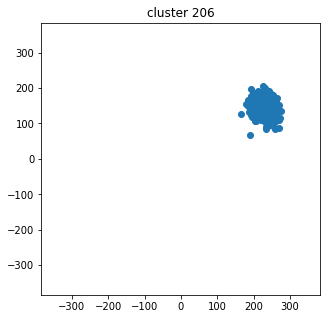

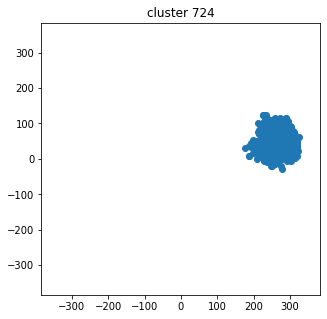

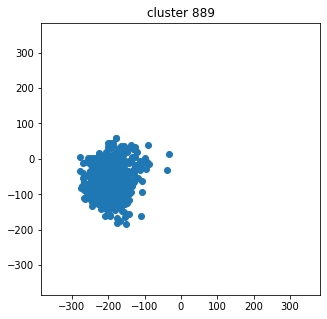

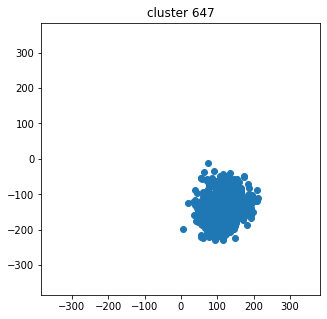

In [32]:
labels_sample = sample(list(np.unique(labels)), 5)
for label in labels_sample:
    plot_clustering(dataset, labels, label)

### HNSW Plotting

#### Plotting routine

In [13]:
def plot_HNSW(g:HNSW_Graph, d:Dataset, only_layer=None):
    all_values = [abs(e[0]) for e in d.pca_db] + [abs(e[1]) for e in d.pca_db]
    limit = max(all_values)
    limit += limit/10
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    fig = plt.gcf()
    if only_layer != None:
        fig.set_size_inches(5, 5)
    else:
        fig.set_size_inches(10, 10)

    for layer in range(g.height):
        if only_layer==None or layer==only_layer:
            x = []
            y = []
            for index, node in enumerate(g.nodes):
                if node.get_height() > layer:
                    x.append(d.pca_db[index][0])
                    y.append(d.pca_db[index][1])
            plt.scatter(x, y, label=f"layer {layer}")

    if only_layer != None:
        plt.title(f"layer size = {len(x)}")
    plt.legend()
    plt.show()

#### HNSW

In [4]:
with open(f'../data/hnsw_{db_name}.pkl', 'rb') as file:
    hnsw = pickle.load(file)

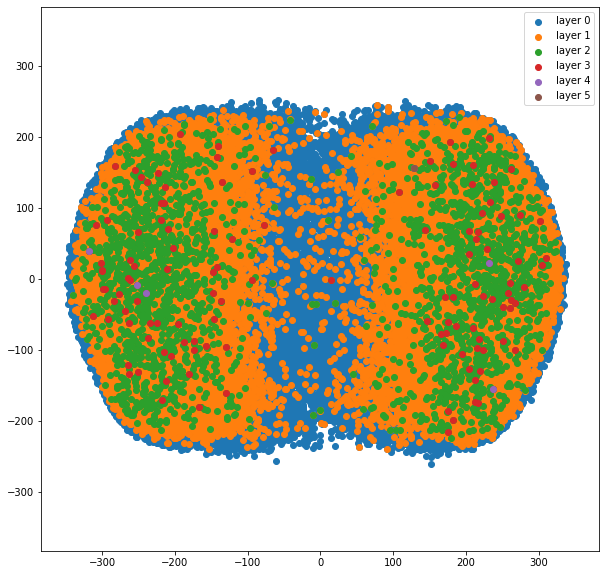

In [13]:
plot_HNSW(hnsw.graph, dataset)

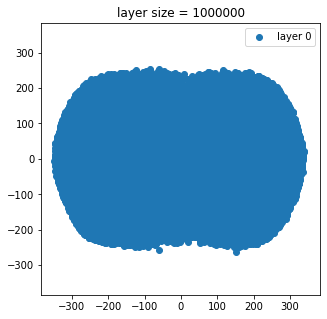

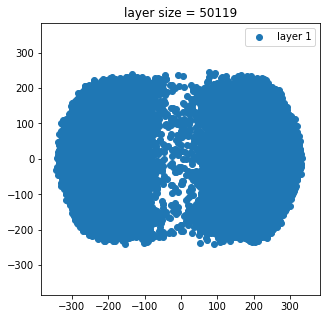

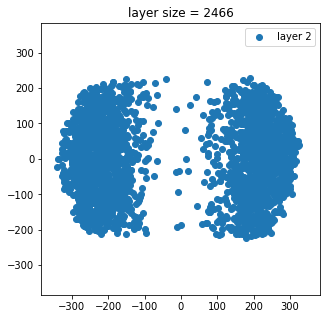

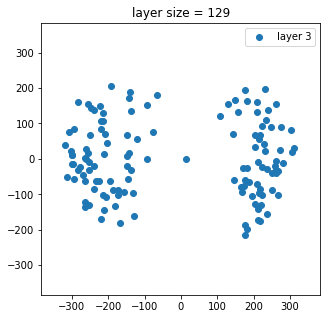

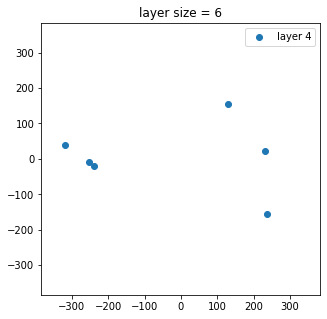

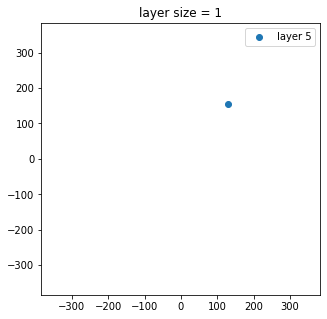

In [14]:
for layer in range(hnsw.graph.height):
    plot_HNSW(hnsw.graph, dataset, layer)

#### BiscectingKMeans HNSW

In [12]:
with open(f'../data/bhnsw_{db_name}.pkl', 'rb') as file:
    bhnsw = pickle.load(file)

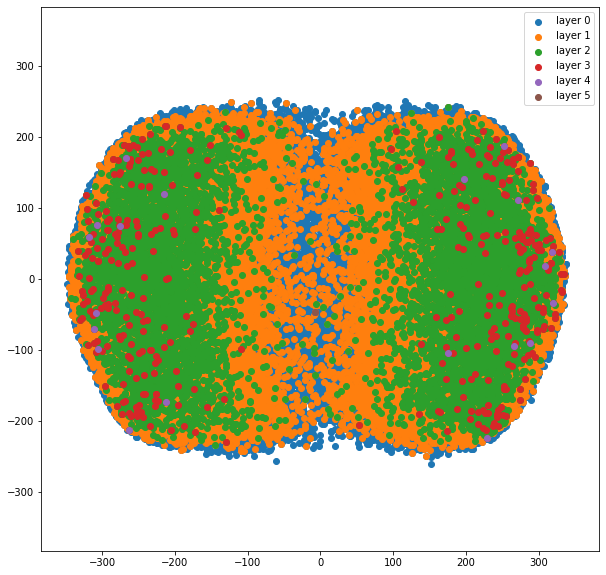

In [14]:
plot_HNSW(bhnsw.graph, dataset)

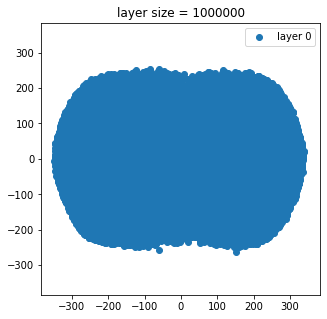

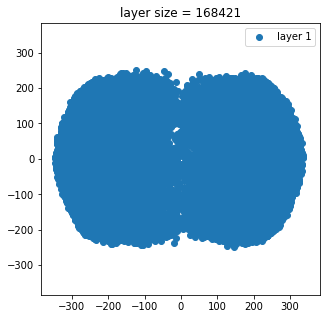

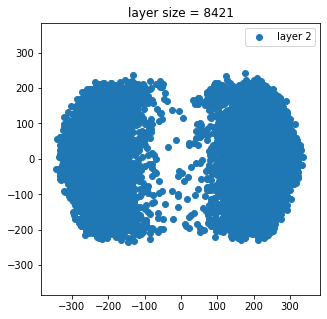

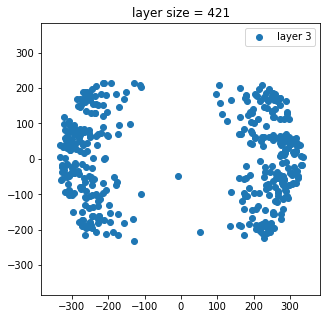

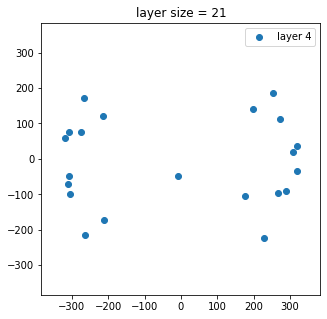

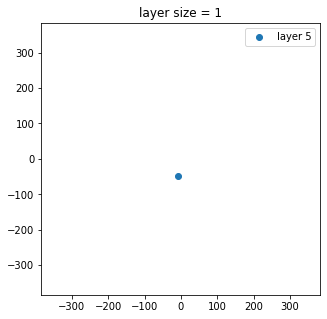

In [15]:
for layer in range(bhnsw.graph.height):
    plot_HNSW(bhnsw.graph, dataset, layer)